# Optimal Realized Volatility Prediction

The goal of this competition is to predict volatility of stocks. Before we get in to modeling process, let's start with exploring and visualizing given datasets!

## Contents
1. [Load package and data](#intro)
2. [Basic Preprocessing](#prepro)
3. [EDA](#eda)

## 1. Load package and data <a class="anchor" id="intro"></a>

In [1]:
import numpy as np 
import pandas as pd 
import pyarrow.parquet as pq
import glob

import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

**target** variable in train data represents volatility of stock under same stock_id and time_id. This dataset only contains target variable, so to get more information about dataset, with should take a look at other given datasets.

In [2]:
# load data
train = pd.read_csv("../input/optiver-realized-volatility-prediction/train.csv", header = 0)
train.head()

,stock_id,time_id,target
0,0,5,0.004136
1,0,11,0.001445
2,0,16,0.002168
3,0,31,0.002195
4,0,62,0.001747


In [3]:
book_filepath = "/kaggle/input/optiver-realized-volatility-prediction/book_train.parquet"
trade_filepath = "/kaggle/input/optiver-realized-volatility-prediction/trade_train.parquet"

# get filenames in book and trade files
book_filenames = os.listdir(book_filepath)
trade_filenames = os.listdir(trade_filepath)

print(book_filenames[:10])

['stock_id=97', 'stock_id=43', 'stock_id=21', 'stock_id=72', 'stock_id=4', 'stock_id=112', 'stock_id=22', 'stock_id=105', 'stock_id=116', 'stock_id=63']


In [4]:
# sample book data
sample = pd.read_parquet(os.path.join(book_filepath, book_filenames[0]))
sample.head(3)

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
0,5,0,1.000135,1.002019,1.000096,1.002596,200,202,200,1
1,5,1,1.000135,1.002019,1.000096,1.002596,300,324,100,1
2,5,2,1.000135,1.001981,1.000096,1.002019,200,100,100,121


In [5]:
# sample train data
sample2 = pd.read_parquet(os.path.join(trade_filepath, trade_filenames[0]))
sample2.head(3)

,time_id,seconds_in_bucket,price,size,order_count
0,5,10,1.000942,100,1
1,5,43,1.001984,234,5
2,5,45,1.002558,101,4


## Confusing variables
It's quite hard to understand columns in book and trade data at first glance. So I carefully read [tutorial notebook](https://www.kaggle.com/jiashenliu/introduction-to-financial-concepts-and-data) and [Q&A](https://www.kaggle.com/c/optiver-realized-volatility-prediction/discussion/249752) to well understand confusing columns in dataset.

### time_id
Represents unique 10-minutes trading window. It does not have special meanings, it just seperates data in each trading window. Plus, bigger time_id value does not necessarily mean later time.
<br>
### seconds_in_bucket
#### 1. book 
Briefly, seconds_in_bucket represents the last snapshot of order book update. If `seconds_in_bucket` = 20, it captures last order between 12:00:20 and 12:00:21. If you take a look at **book_train.parquet** data, per time_id, it ranges from 0 to 599, since 10-miutes is same as 600 seconds. There are some missing seconds_in_bucket values in book data which means that there is no related market activities during that second.
<br>
#### 2. trade 
Under same stock_id and time_ida, if seconds_in_bucket=1, this represents aggregation of all individual executed orders between 12:00:00 and 12:00:01. In trade data, there are some gaps between second_in_bucket values. This shows that there is no trade happening in this seconds_in_bucket window.
<br>
### target
**target** in train data is volatility of stock. It is calculated under same equation of **realized volatility** in tutorial notebook

## Basic Preprocessing <a class="anchor" id="prepro"></a>
 

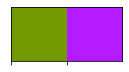

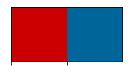

In [6]:
# colors 
mycolors = ['#739900', '#b31aff']
bidask_color = ['#cc0000', '#006699']
sns.palplot(mycolors)
sns.palplot(bidask_color)

Define functions that calcualted **log_return** and **realized_volatility**. This code is in [tutorial notebook](https://www.kaggle.com/jiashenliu/introduction-to-financial-concepts-and-data).

In [7]:
def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff() 

def realized_volatility(series_log_return):
    return np.sqrt(np.sum(series_log_return**2))

In book data, there are two prices/sizes for ask and bid each. Therefore I created **wap1, wap2, log_return1, log_return2**, each represents wap and log return from each bid/ask price field (1 & 2).

In [8]:
def get_book_data(stock_id, filepath):
    path = os.path.join(filepath, f"stock_id={stock_id}".format(stock_id))
    data = pd.read_parquet(path)
    data.insert(0, 'stock_id', stock_id)
    data['wap1'] = (data['bid_price1'] * data['ask_size1'] + data['ask_price1'] * data['bid_size1']) / (data['bid_size1']+ data['ask_size1'])
    data['wap2'] = (data['bid_price2'] * data['ask_size2'] + data['ask_price2'] * data['bid_size2']) / (data['bid_size2']+ data['ask_size2'])
    data['log_return1'] = data.groupby(['time_id'])['wap1'].apply(log_return)
    data['log_return2'] = data.groupby(['time_id'])['wap2'].apply(log_return)
    data = data[~data['log_return1'].isnull()]
    data = data[~data['log_return2'].isnull()]
    return data

def get_book_volatility(data):
    data = data.groupby(['stock_id', 'time_id'])['log_return1', 'log_return2'].agg(realized_volatility).reset_index()
    data.rename(columns = {'log_return1': 'volatility1', 'log_return2': 'volatility2'}, inplace = True)
    return data

def get_trade_data(stock_id, filepath):
    path = os.path.join(filepath, f"stock_id={stock_id}".format(stock_id))
    data = pd.read_parquet(path)
    data.insert(0, 'stock_id', stock_id)
    return data

## EDA <a class="anchor" id="eda"></a>

In EDA part, I'll discuss 
1. General understanding of book data  
2. Comparision between two stocks (stock_id 0 vs stock_id 43)


<br>

Let's define variables as below.
* `book_0`: book data of stock_id = 0
* `book_43`: book data of stock_id = 43
* `trade_0`: trade data of stock_id = 0
* `trade_43`: trade data of stock_id = 43

In [9]:
# define datasets
book_0 = get_book_data(0, book_filepath)
book_43 = get_book_data(43, book_filepath)

trade_0 = get_trade_data(0, trade_filepath)
trade_43 = get_trade_data(43, trade_filepath)

In [10]:
# stock_id & time_id data
book_0_time_5 = book_0[book_0['time_id'] == 5]
book_0_time_16 = book_0[book_0['time_id'] == 16]

book_43_time_5 = book_43[book_43['time_id'] == 5]
book_43_time_16 = book_43[book_43['time_id'] == 16]

### (1) General understanding of book data

**book data** contains columns related to bid/ask price and size and we created new variables wap and log return. To well-understand data, let's take a look at **bid & ask**.


<br>

#### What is bid & ask ?
The **bid price** represents the maximum price that a buyer is willing to pay for a share of stock. The **ask price**(or offer price) represents the minimum price that a seller is willing to take for a share of stock. 
Ask price is always higher than bid price. To check this, I draw price graph for bid & ask price. Now it's clear that ask price is higher than bid price. (I used stock_id = 0 & time_id = 5 to visualize this below graph)


#### Bid-Ask spread
Bid-Ask spread represents price difference between bid price and ask price. If bid-ask spread is small, this means that stock's liquidity is high. 
According to this [page](https://www.investor.gov/introduction-investing/investing-basics/glossary/liquidity-or-marketability), liquidity refers to how easily or quickly a stock can be bought or sold in a secondary market. It's easier to sell stocks with high liquidity. <br>
In graph below, the green line represents seconds_in_bucket where bid-ask spread is smallest. At this point, stock 0 is most liquid.

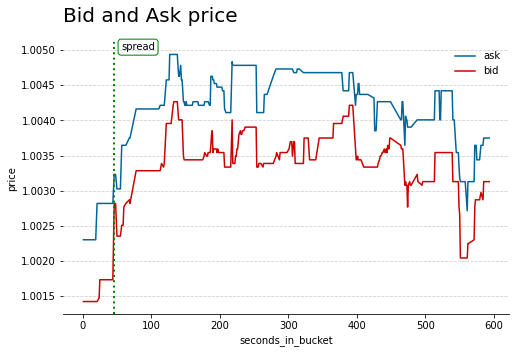

In [11]:
# ask price is always greater than bid price
plt.figure(figsize = (8, 5))
ax = plt.subplot(1, 1, 1)
sns.lineplot(data = book_0_time_5, x = 'seconds_in_bucket', y = 'ask_price1', label = 'ask', color = bidask_color[1])
sns.lineplot(data = book_0_time_5, x = 'seconds_in_bucket', y = 'bid_price1', label = 'bid', color = bidask_color[0])

# bid-ask spread
book_0_time_5['spread'] = book_0_time_5['ask_price1'] - book_0_time_5['ask_price2']
# minimum bid-ask spread
idx = np.argmin(book_0_time_5['spread'])

plt.axvline(book_0_time_5.iloc[idx, :]['seconds_in_bucket'], linestyle = ':', color = 'green', linewidth = 2)
plt.text(book_0_time_5.iloc[idx, :]['seconds_in_bucket']+10, 1.0050, 'spread', 
         bbox = dict(facecolor ='none', edgecolor='green', boxstyle='round'))

for i in ['left', 'right', 'top']:
    ax.spines[i].set_visible(False)

ax.set_axisbelow(True)
ax.grid(axis='y', linestyle='--', alpha = 0.6)

plt.title('Bid and Ask price', fontsize = 20, loc = 'left', pad = 20)
plt.ylabel('price');
plt.legend(bbox_to_anchor = (0.5, 0.5, 0.5, 0.5), frameon = False)
plt.show()

#### Net Size
Now I defined **net_size**, difference between bid size and ask size: **bid_size - ask_size**
<br>

When the net_size is smaller than 0(bid size < ask size), this means the price is likely to move down because there are more traders selling(ask) than buying(bid). When net size is greater than 0(bid size > ask size), there is more demand than supply and prices tend to go up. 
<br>

I labeled **pos** for data with net_size > 0, and **neg** for data with net_size < 0.

In [12]:
book_0_time_5['net_size'] = book_0_time_5['bid_size1'] - book_0_time_5['ask_size1']
book_0_time_5['net'] = ['neg' if x < 0 else 'pos' for x in book_0_time_5['net_size'].values]

book_0_time_16['net_size'] = book_0_time_16['bid_size1'] - book_0_time_16['ask_size1']
book_0_time_16['net'] = ['neg' if x < 0 else 'pos' for x in book_0_time_16['net_size'].values]

In [13]:
# plot net_size - wap
def net_size_data(data, stock_id, time_id):
    plt.figure(figsize = (8, 5))
    ax = plt.subplot(1, 1, 1)
    sns.scatterplot(data = data, x = 'seconds_in_bucket', y = 'wap1',  hue = 'net', hue_order = ['neg', 'pos'],
                    palette = bidask_color)

    for i in ['left', 'right', 'top']:
        ax.spines[i].set_visible(False)
    
    legend = plt.legend(frameon = False, bbox_to_anchor = (0.5, 0.5, 0.5, 0.5), scatterpoints = 1)
    legend.legendHandles[0]._sizes = [40]
    plt.title(f'Stock {stock_id} - time {time_id}: WAP fluctuation', fontsize = 20, pad = 20, loc = 'left')
    plt.show()

When bid size is smaller than ask size(red points), WAP tends to go down generally as you can check in below graph. In opposite case, WAP tends to go up.

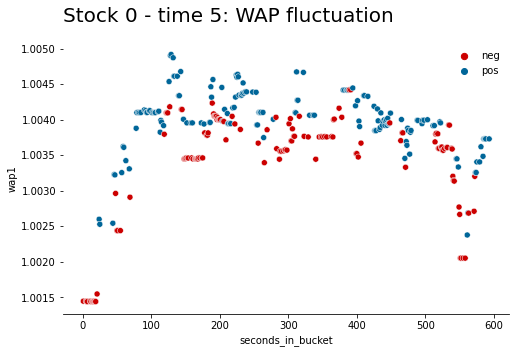

In [14]:
net_size_data(book_0_time_5, 0, 5)

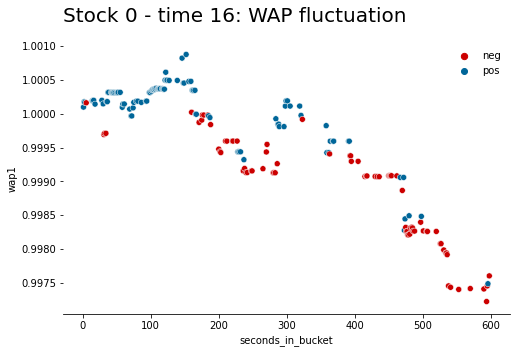

In [15]:
net_size_data(book_0_time_16, 0, 16)

In [Basic Preprocessing](#prepro) part, I created **wap1** and **wap2** variable. To check whether wap1 and wap2 show difference, I plotted wap1 and wap2 of stock 0 data.  time_1 denotes time_id = 5, and time_2 denotes time_id = 16.

<br>

Comparing graphs, overall fluctuation of wap1 and wap2 under same stock_id/time_id are very similar!

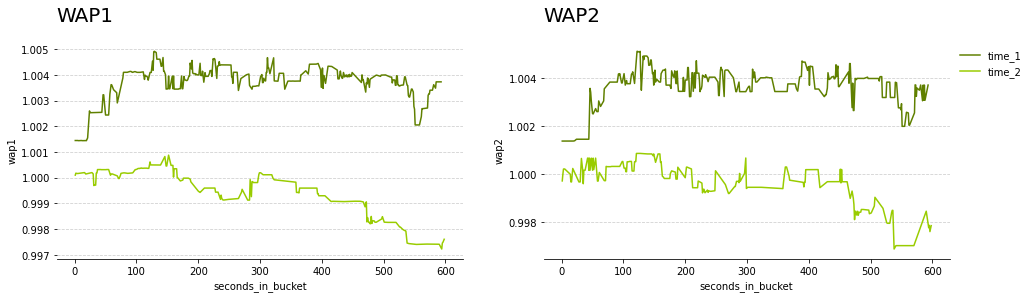

In [16]:
book_0_list = [book_0_time_5, book_0_time_16]
colors_0 = ['#608000', '#99cc00', '#d2ff4d']


fig, axes = plt.subplots(figsize = (16, 4), ncols = 2)
for i, dat in enumerate(book_0_list):
    sns.lineplot(data = dat, x = 'seconds_in_bucket', y = 'wap1', label = str('time_')+str(i+1), ax = axes[0], 
                 legend = None, color = colors_0[i])
    
for i, dat in enumerate(book_0_list):
    sns.lineplot(data = dat, x = 'seconds_in_bucket', y = 'wap2', label = str('time_')+str(i+1), ax = axes[1],
                color = colors_0[i])
    
for i in ['left', 'right', 'top']:
    axes[0].spines[i].set_visible(False)
    axes[1].spines[i].set_visible(False)
    
axes[0].grid(axis='y', linestyle='--', alpha = 0.6)
axes[1].grid(axis='y', linestyle='--', alpha = 0.6)
axes[1].legend(bbox_to_anchor = (0.7, 0.5, 0.5, 0.5),frameon = False)


axes[0].set_title('WAP1', fontsize = 20, pad = 20, loc = 'left')
axes[1].set_title('WAP2', fontsize = 20, pad = 20, loc = 'left')
plt.show()

Correlation coefficient between wap1 and wap2 under same stock_id/time_id is **0.78**, which means that wap1 and wap2 are highly correlated.


To summarize, it will be enough to use only wap from bid/ask price field 1 to predict target volatility, since wap1 and wap2 shows similar patterns.

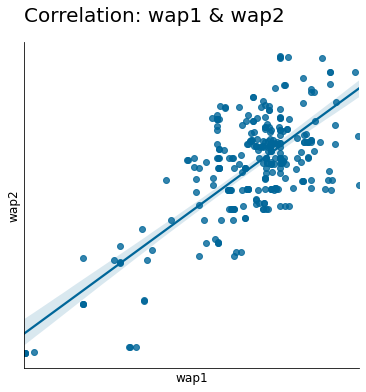

In [17]:
plt.figure(figsize = (6, 6))
ax = sns.regplot(data = book_0_time_5, x = 'wap1', y = 'wap2', color = bidask_color[1])

for i in ['right','top']:
    ax.spines[i].set_visible(False)
    ax.spines[i].set_visible(False)

ax.set_xlabel('wap1', fontsize = 12)
ax.set_ylabel('wap2', fontsize = 12)
plt.xticks([]); plt.yticks([])
plt.title('Correlation: wap1 & wap2', fontsize = 20, loc = 'left', pad = 20)
plt.show()

### (2) Comparision between two stocks: Stock 0 vs Stock 43

There are 112 unique stock_id in book/trade files...hard to compare all stock_ids! Hence I randomly chose two stock_id 0 and 43 to compare those stocks, just for fun!



Both stock 0 and stock 43 shows different WAP fluctuation according to time_id. This is why we have to predict target in test data based on unique (stock_id, time_id) combinations.
 

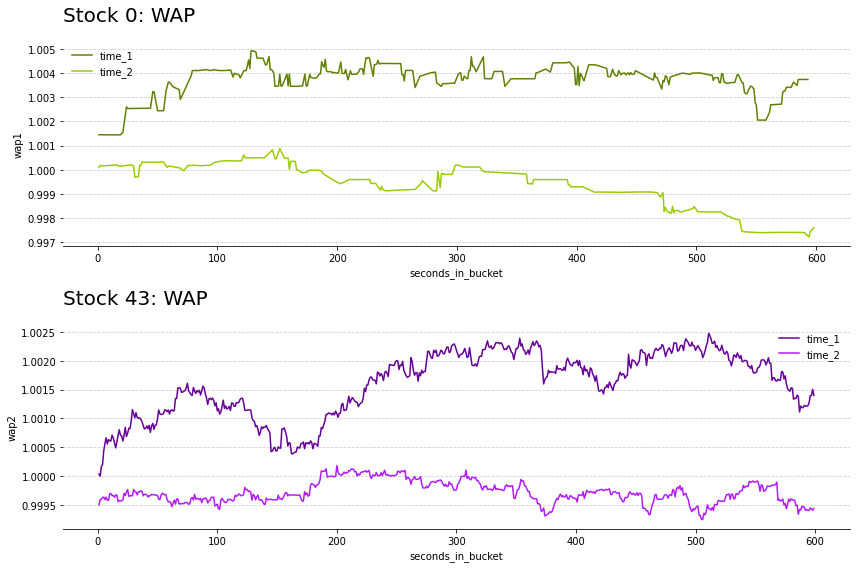

In [18]:
book_0_list = [book_0_time_5, book_0_time_16]
book_43_list = [book_43_time_5, book_43_time_16]
colors_43 = ['#660099', '#b31aff', '#eeccff']

fig, axes = plt.subplots(figsize = (12, 8), nrows = 2)
for i, dat in enumerate(book_0_list):
    sns.lineplot(data = dat, x = 'seconds_in_bucket', y = 'wap1', label = str('time_')+str(i+1), ax = axes[0]
                 , color = colors_0[i])
    
for i, dat in enumerate(book_43_list):
    sns.lineplot(data = dat, x = 'seconds_in_bucket', y = 'wap2', label = str('time_')+str(i+1), ax = axes[1], color = colors_43[i])
    
for i in ['left', 'right', 'top']:
    axes[0].spines[i].set_visible(False)
    axes[1].spines[i].set_visible(False)
    
axes[0].grid(axis='y', linestyle='--', alpha = 0.6)
axes[1].grid(axis='y', linestyle='--', alpha = 0.6)

axes[0].legend(frameon = False)
axes[1].legend(frameon = False)


axes[0].set_title('Stock 0: WAP', fontsize = 20, pad = 20, loc = 'left')
axes[1].set_title('Stock 43: WAP', fontsize = 20, pad = 20, loc = 'left')
plt.tight_layout()
plt.show()

I've used only book data to understand and visualize data. Now let's use trade data to get more interpretations. Each file in trade data has those columns.
+ price: The average price of executed transactions happening in one second. Prices have been normalized and the average has been weighted by the number of shares traded in each transaction.
+ size: The sum number of shares traded.
+ order_count: The number of unique trade orders taking place.

In [19]:
# define trade data
trade0_time_5 = trade_0[trade_0['time_id'] == 5]
trade0_time_16 = trade_0[trade_0['time_id']==16]

trade43_time_5 = trade_43[trade_43['time_id'] == 5]
trade43_time_16 = trade_43[trade_43['time_id']==16]

In [20]:
# get volatility of each stock
book0_vol = get_book_volatility(book_0)
book43_vol = get_book_volatility(book_43)

The graph below shows price fluctuation of stocks that are actually traded. Size of dots denotes **transaction size** of stocks: the bigger the size of dots, more transaction occured.


#### Comparision of Stock 0 and Stock 43
 + The overall transaction size of Stock 0 is smaller than that of Stock 43(compare size of dots in each graph!)
 + Trade of Stock 0 happening in stock market is much sparser than that of Stock 43. There is comparatively large distance between transcation points in Stock 0.
 + Volatility is slightly greater in Stock 0 than in Stock 43.

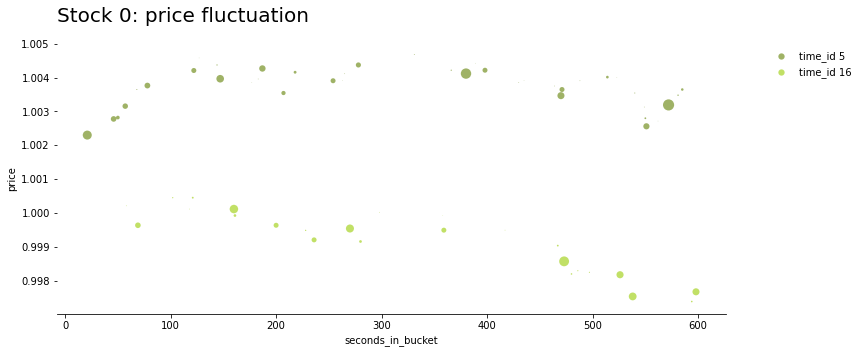

In [21]:
def plot_price_fluc(data1, data2, stock_id, color):
    plt.figure(figsize = (12, 5))
    ax = plt.subplot(1, 1, 1)
    sns.scatterplot(data = data1, x = 'seconds_in_bucket', y = 'price', s = data1['size']/4
                , color = color[0], label = 'time_id 5', alpha = 0.6)
    sns.scatterplot(data = data2, x = 'seconds_in_bucket', y = 'price', s = data2['size']/4
                , color = color[1], label = 'time_id 16', alpha = 0.6)



    for i in ['left', 'right', 'top']:
        ax.spines[i].set_visible(False)
    
    legend = plt.legend(frameon = False, bbox_to_anchor = (0.7, 0.5, 0.5, 0.5), scatterpoints = 1)
    legend.legendHandles[0]._sizes = [40]
    legend.legendHandles[1]._sizes = [40]
    plt.title(f'Stock {stock_id}: price fluctuation', fontsize = 20, pad = 20, loc = 'left')
    plt.show()
    
    
plot_price_fluc(trade0_time_5, trade0_time_16, 0, colors_0)

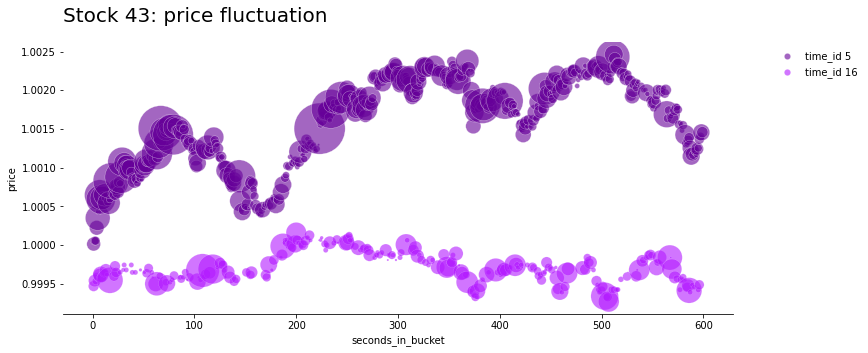

In [22]:
plot_price_fluc(trade43_time_5, trade43_time_16, 43, colors_43)

Compare overall volatility of Stock 0 and Stock 43! <br>


#### Volatility
Volatiliy of Stock 43 tends to be smaller than that of Stock 0, and it's highly dense in volatiliy range between 0 and 0.005.

In [23]:
book0_vol[(book0_vol['time_id'] == 5)| (book0_vol['time_id'] == 16)]

,stock_id,time_id,volatility1,volatility2
0,0,5,0.004499,0.006999
2,0,16,0.002369,0.004801


In [24]:
book43_vol[(book43_vol['time_id'] == 5)| (book43_vol['time_id'] == 16)]

,stock_id,time_id,volatility1,volatility2
0,43,5,0.001867,0.001970
2,43,16,0.001128,0.001293


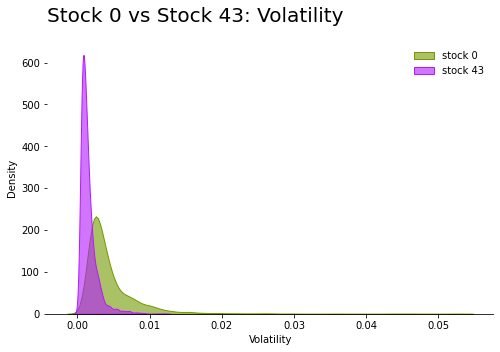

In [25]:
plt.figure(figsize = (8, 5))
ax = plt.subplot(1, 1, 1)
sns.kdeplot(book0_vol['volatility1'],fill = True, alpha = 0.6, label = 'stock 0', color = mycolors[0])
sns.kdeplot(book43_vol['volatility1'], fill = True, alpha = 0.6, label = 'stock 43', color = mycolors[1])

for i in ['left', 'right', 'top']:
    ax.spines[i].set_visible(False)

plt.xlabel('Volatility')
plt.title('Stock 0 vs Stock 43: Volatility', fontsize = 20, loc = 'left', pad = 20)
plt.legend(frameon = False)
plt.show()

# Thank you for reading this notebook :)